# M5 Walmart Accuracy Forecasting EDA

- 42,840 time series present
- 28 days ahead point forecasts required
- Median, 50%, 67%, 95% and 99% prediction intervals

## Some data nuances:
- First, it uses grouped unit sales data, starting at the product-store level and being aggregated to that of product departments, product categories, stores, and three geographical areas: the States of California (CA), Texas (TX), and Wisconsin (WI).
- Second, besides the time series data, it includes explanatory variables such as **sell prices, promotions, days of the week, and special events (e.g. Super Bowl, Valentine’s Day, and Orthodox Easter)** that typically affect unit sales and could improve forecasting accuracy.
- Third, in addition to point forecasts, it assesses the distribution of uncertainty, as the participants are asked to provide information on nine indicative quantiles.
- Fourth, instead of having a single competition to estimate both the point forecasts and the uncertainty distribution, there will be two parallel tracks using the same dataset, the first requiring 28 days ahead point forecasts and the second 28 days ahead probabilistic forecasts for the median and four prediction intervals (50%, 67%, 95%, and 99%).
- Fifth, for the first time it focuses on series that display intermittency, i.e., sporadic demand including zeros.


## The dataset
- Made available by Walmart
- Organized in the form of grouped time series
- Contains the unit sales of 3,049 products classified in 
    - 3 product categories (Hobbies, Food and Household)
    - 7 product departments
    - 10 stores
    - Three states (CA, TX, WI)
    
   

![](heirarchy.png)
    

## Data Ranges
- Historical Data Range is from 2011-01-29 to 2016-06-19
- Max selling history of 1,941 days or 5.4 years

## Files metadata:

### File 1: “calendar.csv” 
Contains information about the dates the products are sold.
- date: The date in a “y-m-d” format.
- wm_yr_wk: The id of the week the date belongs to.
- weekday: The type of the day (Saturday, Sunday, …, Friday).
- wday: The id of the weekday, starting from Saturday.
- month: The month of the date.
- year: The year of the date.
- event_name_1: If the date includes an event, the name of this event.
- event_type_1: If the date includes an event, the type of this event.
- event_name_2: If the date includes a second event, the name of this event.
- event_type_2: If the date includes a second event, the type of this event.
- snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP  purchases on the examined date. 1 indicates that SNAP purchases are allowed.


### File 2: “sell_prices.csv”
Contains information about the price of the products sold per store and date.
- store_id: The id of the store where the product is sold. 
- item_id: The id of the product.
- wm_yr_wk: The id of the week.
- sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set). 


### File 3: “sales_train_validation.csv” 
Contains the historical daily unit sales data per product and store. [d 1 - d 1913]
- item_id: The id of the product.
- dept_id: The id of the department the product belongs to.
- cat_id: The id of the category the product belongs to.
- store_id: The id of the store where the product is sold.
- state_id: The State where the store is located.
- d_1, d_2, …, d_i, … d_1941: The number of units sold at day i, starting from 2011-01-29. 


### File 4: "sales_train_evaluation.csv"
Includes sales [d_1 - d_1941] (labels used for the Public leaderboard)


In [30]:
# Importing libraries
import pandas as pd
import numpy as np

In [31]:
#Reading in the data
calendar_df = pd.read_csv("../data/calendar.csv")
sales_price_df = pd.read_csv("../data/sell_prices.csv")
train_df = pd.read_csv("../data/sales_train_validation.csv")
eval_df = pd.read_csv("../data/sales_train_evaluation.csv")

In [32]:
calendar_df.head(10)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0


In [33]:
calendar_df.tail(10)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
1959,2016-06-10,11619,Friday,7,6,2016,d_1960,NaN,NaN,NaN,NaN,1,0,0
1960,2016-06-11,11620,Saturday,1,6,2016,d_1961,NaN,NaN,NaN,NaN,0,1,1
1961,2016-06-12,11620,Sunday,2,6,2016,d_1962,NaN,NaN,NaN,NaN,0,1,1
1962,2016-06-13,11620,Monday,3,6,2016,d_1963,NaN,NaN,NaN,NaN,0,1,0
1963,2016-06-14,11620,Tuesday,4,6,2016,d_1964,NaN,NaN,NaN,NaN,0,0,1
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0
1968,2016-06-19,11621,Sunday,2,6,2016,d_1969,NBAFinalsEnd,Sporting,Father's day,Cultural,0,0,0


#### What is SNAP?
SNAP, the Supplemental Nutrition Assistance Program, is the program formerly known as food stamps. It is a federal nutrition program that helps you stretch your food budget and buy healthy food.

SNAP benefits can be used to purchase food at grocery stores, convenience stores, and some farmers' markets and co-op food programs.

SNAP benefits are given to you each month on a plastic card called an EBT (electronic benefits transfer) card, which works like a debit card. Paper coupons are no longer used.

SNAP is a nutrition program. It is not a welfare cash assistance program (which is called TAFDC). You do not have to be receiving TAFDC to get SNAP — these are separate programs.

SNAP is a federal entitlement program. This means anyone who is eligible will receive benefits. You will not be taking away benefits from someone else if you apply.

The United States Department of Agriculture (USDA) oversees SNAP at the federal level.

In [34]:
print(calendar_df.date.min())
print(calendar_df.date.max())
print("----1")
print(calendar_df.shape)
print(calendar_df.date.nunique())
print("----2")
print(calendar_df.snap_CA.sum())
print(calendar_df.snap_TX.sum())
print(calendar_df.snap_WI.sum())
print("----3")
print(calendar_df.groupby(["month", "year"]).count().reset_index().shape)
print("----4")
print(calendar_df.event_name_1.value_counts())
print("----5")
print(calendar_df.event_name_1.count())

2011-01-29
2016-06-19
----1
(1969, 14)
1969
----2
650
650
650
----3
(66, 14)
----4
SuperBowl              6
Mother's day           6
ValentinesDay          6
Pesach End             6
PresidentsDay          6
MemorialDay            6
NBAFinalsStart         6
Purim End              6
Ramadan starts         6
NBAFinalsEnd           6
LentWeek2              6
LentStart              6
StPatricksDay          6
OrthodoxChristmas      5
IndependenceDay        5
Chanukah End           5
Halloween              5
Eid al-Fitr            5
NewYear                5
Cinco De Mayo          5
Thanksgiving           5
EidAlAdha              5
MartinLutherKingDay    5
Christmas              5
LaborDay               5
Easter                 5
VeteransDay            5
ColumbusDay            5
OrthodoxEaster         5
Father's day           4
Name: event_name_1, dtype: int64
----5
162


- First Month (2011-01) has only three days (29, 30, 31)
- Last mMonth (2016-06) has only 19 days (1 - 19)

In [35]:
calendar_df[calendar_df.snap_CA == 1].head(30)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
6,2011-02-04,11101,Friday,7,2,2011,d_7,NaN,NaN,NaN,NaN,1,0,0
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0
10,2011-02-08,11102,Tuesday,4,2,2011,d_11,NaN,NaN,NaN,NaN,1,0,1
11,2011-02-09,11102,Wednesday,5,2,2011,d_12,NaN,NaN,NaN,NaN,1,1,1
12,2011-02-10,11102,Thursday,6,2,2011,d_13,NaN,NaN,NaN,NaN,1,0,0


In [36]:
calendar_df[calendar_df.snap_TX == 1].head(50)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
9,2011-02-07,11102,Monday,3,2,2011,d_10,NaN,NaN,NaN,NaN,1,1,0
11,2011-02-09,11102,Wednesday,5,2,2011,d_12,NaN,NaN,NaN,NaN,1,1,1
13,2011-02-11,11102,Friday,7,2,2011,d_14,NaN,NaN,NaN,NaN,0,1,1
14,2011-02-12,11103,Saturday,1,2,2011,d_15,NaN,NaN,NaN,NaN,0,1,1
15,2011-02-13,11103,Sunday,2,2,2011,d_16,NaN,NaN,NaN,NaN,0,1,0
17,2011-02-15,11103,Tuesday,4,2,2011,d_18,NaN,NaN,NaN,NaN,0,1,1


In [37]:
calendar_df[calendar_df.snap_WI == 1].head(50)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
5,2011-02-03,11101,Thursday,6,2,2011,d_6,NaN,NaN,NaN,NaN,1,1,1
7,2011-02-05,11102,Saturday,1,2,2011,d_8,NaN,NaN,NaN,NaN,1,1,1
8,2011-02-06,11102,Sunday,2,2,2011,d_9,SuperBowl,Sporting,NaN,NaN,1,1,1
10,2011-02-08,11102,Tuesday,4,2,2011,d_11,NaN,NaN,NaN,NaN,1,0,1
11,2011-02-09,11102,Wednesday,5,2,2011,d_12,NaN,NaN,NaN,NaN,1,1,1
13,2011-02-11,11102,Friday,7,2,2011,d_14,NaN,NaN,NaN,NaN,0,1,1
14,2011-02-12,11103,Saturday,1,2,2011,d_15,NaN,NaN,NaN,NaN,0,1,1
16,2011-02-14,11103,Monday,3,2,2011,d_17,ValentinesDay,Cultural,NaN,NaN,0,0,1
17,2011-02-15,11103,Tuesday,4,2,2011,d_18,NaN,NaN,NaN,NaN,0,1,1


SNAP days follow different patterns in different states:
- In CA, it is 1st to 10th depending on last digit of case number
- In TX, it is 10/first 15 days depending on last digit of your EDG number
- In WI, it is 10/first 15 days depending on last digit of your SSN number

Overall, it is 10 fixed days per month

In [38]:
#Looking at sales price df
sales_price_df.head(20)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
5,CA_1,HOBBIES_1_001,11330,8.26
6,CA_1,HOBBIES_1_001,11331,8.26
7,CA_1,HOBBIES_1_001,11332,8.26
8,CA_1,HOBBIES_1_001,11333,8.26
9,CA_1,HOBBIES_1_001,11334,8.26


10
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']
3049


count    6.841121e+06
mean     4.410952e+00
std      3.408814e+00
min      1.000000e-02
25%      2.180000e+00
50%      3.470000e+00
75%      5.840000e+00
max      1.073200e+02
Name: sell_price, dtype: float64

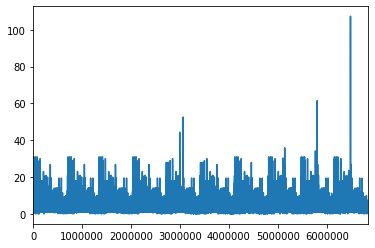

In [39]:
print(sales_price_df.store_id.nunique())
print(sales_price_df.store_id.unique())
print(sales_price_df.item_id.nunique())
sales_price_df.sell_price.plot()
sales_price_df.sell_price.describe()

- There are ten stores across the three states. 4 in California, 3 in Texas and 3 in Wisconsin
- A total of 3049 products with majority of the prices between 0 and 30 with the max slightly more than 100

In [40]:
sales_price_df[sales_price_df.sell_price < 0.05]

,store_id,item_id,wm_yr_wk,sell_price
225727,CA_1,HOUSEHOLD_1_443,11442,0.01
1394085,CA_3,HOBBIES_1_261,11332,0.01
1394086,CA_3,HOBBIES_1_261,11333,0.01
1394087,CA_3,HOBBIES_1_261,11334,0.01
2617306,CA_4,FOODS_3_413,11148,0.01
4708579,TX_3,FOODS_3_410,11334,0.02
4728843,TX_3,FOODS_3_498,11324,0.02
4877375,WI_1,HOBBIES_1_338,11342,0.01
4877376,WI_1,HOBBIES_1_338,11343,0.01
5044267,WI_1,HOUSEHOLD_1_533,11408,0.01


In [41]:
sales_price_df['item_id_sub'] = sales_price_df.item_id.str[:-4]
print(sales_price_df.item_id_sub.unique())
print(sales_price_df.store_id.unique())

['HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1' 'HOUSEHOLD_2' 'FOODS_1' 'FOODS_2'
 'FOODS_3']
['CA_1' 'CA_2' 'CA_3' 'CA_4' 'TX_1' 'TX_2' 'TX_3' 'WI_1' 'WI_2' 'WI_3']


- We have a few items with prices less than 5 cents
- Item ID contains department and category information

In [42]:
#Looking at sales_train_validation.csv
print(train_df.shape)

(30490, 1919)


In [43]:
train_df.head(20)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4
5,HOBBIES_1_006_CA_1_validation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,1,0,0,0,2,0,0
6,HOBBIES_1_007_CA_1_validation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,1,0,1,0,0,1,1
7,HOBBIES_1_008_CA_1_validation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,...,0,0,1,37,3,4,6,3,2,1
8,HOBBIES_1_009_CA_1_validation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,...,0,0,1,1,6,0,0,0,0,0
9,HOBBIES_1_010_CA_1_validation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,1,0,0,0,0,0,0,2,0,2


In [44]:
train_df[train_df.id.str[:13] == "HOBBIES_1_001"]

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
3049,HOBBIES_1_001_CA_2_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_2,CA,0,0,0,0,...,0,0,1,2,0,4,0,0,2,2
6098,HOBBIES_1_001_CA_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_3,CA,0,0,0,0,...,0,2,4,0,1,1,1,0,3,3
9147,HOBBIES_1_001_CA_4_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_4,CA,0,0,0,0,...,1,0,0,1,0,1,0,1,2,1
12196,HOBBIES_1_001_TX_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_1,TX,0,0,0,0,...,0,0,0,0,1,0,1,0,0,2
15245,HOBBIES_1_001_TX_2_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_2,TX,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
18294,HOBBIES_1_001_TX_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,TX_3,TX,0,0,0,0,...,0,3,0,0,0,0,0,0,0,0
21343,HOBBIES_1_001_WI_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_1,WI,0,0,0,0,...,0,0,0,0,0,0,1,2,1,1
24392,HOBBIES_1_001_WI_2_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_2,WI,0,0,0,0,...,1,1,0,0,0,0,0,0,0,1
27441,HOBBIES_1_001_WI_3_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,WI_3,WI,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [45]:
#Comparing with eval_df
print(eval_df.shape)

(30490, 1947)


In [46]:
eval_df.head(20)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
5,HOBBIES_1_006_CA_1_evaluation,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,0,0,1,0,0,5,2,0
6,HOBBIES_1_007_CA_1_evaluation,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,0,0,0,1,0,1,1,0
7,HOBBIES_1_008_CA_1_evaluation,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,12,15,0,0,...,7,0,6,0,15,5,4,1,40,32
8,HOBBIES_1_009_CA_1_evaluation,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,2,0,7,3,...,1,0,0,0,0,0,0,0,1,0
9,HOBBIES_1_010_CA_1_evaluation,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,0,...,0,0,1,0,2,1,1,0,0,1


- Every product has a row for every store. We have 3,049 products and 10 stores. Hence, 30,490 records
- Eval_df has additional 28 columns with the 28 days of sales information

In [47]:
train_df_fil = train_df[train_df.store_id == "CA_1"]
train_df_piv = pd.melt(train_df_fil, 
                       id_vars = ["item_id", "dept_id", "cat_id", "store_id", "state_id", "id"], 
                       var_name = "d", 
                       value_name = "sales"
                      )

In [48]:
train_df_piv.shape

(5832737, 8)

In [49]:
train_df_piv

,item_id,dept_id,cat_id,store_id,state_id,id,d,sales
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_001_CA_1_validation,d_1,0
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_002_CA_1_validation,d_1,0
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_003_CA_1_validation,d_1,0
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_004_CA_1_validation,d_1,0
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_005_CA_1_validation,d_1,0
5,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_006_CA_1_validation,d_1,0
6,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_007_CA_1_validation,d_1,0
7,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_008_CA_1_validation,d_1,12
8,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_009_CA_1_validation,d_1,2
9,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_010_CA_1_validation,d_1,0


In [50]:
train_df_piv = train_df_piv.merge(calendar_df,how = 'left', on = 'd')

In [51]:
train_df_piv = train_df_piv.merge(sales_price_df,how = 'left', on = ['store_id', 'item_id', 'wm_yr_wk'])

In [52]:
for i in train_df_piv.columns:
    print(i)

item_id
dept_id
cat_id
store_id
state_id
id
d
sales
date
wm_yr_wk
weekday
wday
month
year
event_name_1
event_type_1
event_name_2
event_type_2
snap_CA
snap_TX
snap_WI
sell_price
item_id_sub


In [53]:
train_df_piv.head(10)

,item_id,dept_id,cat_id,store_id,state_id,id,d,sales,date,wm_yr_wk,...,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,item_id_sub
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_001_CA_1_validation,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_002_CA_1_validation,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
2,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_003_CA_1_validation,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
3,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_004_CA_1_validation,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
4,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_005_CA_1_validation,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
5,HOBBIES_1_006,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_006_CA_1_validation,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
6,HOBBIES_1_007,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_007_CA_1_validation,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,NaN,NaN
7,HOBBIES_1_008,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_008_CA_1_validation,d_1,12,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,0.46,HOBBIES_1
8,HOBBIES_1_009,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_009_CA_1_validation,d_1,2,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,1.56,HOBBIES_1
9,HOBBIES_1_010,HOBBIES_1,HOBBIES,CA_1,CA,HOBBIES_1_010_CA_1_validation,d_1,0,2011-01-29,11101,...,2011,NaN,NaN,NaN,NaN,0,0,0,3.17,HOBBIES_1


In [54]:
train_df_piv.memory_usage(deep=True).sum() / 1e9

5.083244615

- Data for one store with all the information merged in is ~5gb. So we will have to optimize the usage of memory while modeling

## Looking at few plots